In [46]:
#Importieren
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [47]:
ratings_raw = pd.read_csv('ratings100k.csv')
movies_raw = pd.read_csv('movies100k.csv')
tmdb_raw = pd.read_csv('tmdb.csv')
df = pd.merge(ratings_raw, movies_raw, on='movieId')
df = pd.merge(tmdb_raw,df, on='movieId')
#Erscheinungsjahr extrahieren
year = df[['movieId','title']].groupby(['movieId','title']).first().reset_index()
year['year'] = year['title'].str.extract(r'\((\d+)\)\s*$')
year = year.drop('title',axis=1)
year = year.set_index('movieId')
#year[pd.isnull(year.year).sort_values(ascending=False)] #Ausnahmen
#year.fillna(1900).astype(int).hist() #Probleme mit NaN Values, ohne Plotten
year = year.fillna(1900).astype(int)
df = pd.merge(df,year,on='movieId')

#Genres in Kategorien splitten
genres = df.genres.str.replace(r'\-','',regex=True).str.replace(r'\s','',regex=True)
cats = ['Action','Adventure','Animation','Children','Comedy','Crime','Documentary', 
'Drama','Fantasy','FilmNoir','Horror','IMAX','Musical','Mystery','Romance','SciFi', 
'Thriller','War','Western','nogenreslisted']
features = cats
cats = "|".join(["(?P<"+x+">"+x+")" for x in cats])
genres.index = df['movieId']
matches = genres.str.extractall(cats)
matches.replace(r'[a-zA-Z]',1,regex=True,inplace=True)
matches = matches.fillna(0).astype(int)
matches = matches.groupby(level=0).max()
#matches[matches.index == 113741]
df = pd.merge(df,matches,on='movieId')

#Userbwertungshistorie - Genres entweder als String oder Matrix 
#Tags hier noch nicht untergebracht 
df.set_index(['userId','movieId'],inplace=True)
df.sort_index(inplace=True)

In [48]:
ratings = df[['rating', 'year', 'Action','Adventure','Animation','Children','Comedy','Crime','Documentary', 
'Drama','Fantasy','FilmNoir','Horror','IMAX','Musical','Mystery','Romance','SciFi', 
'Thriller','War','Western','nogenreslisted']]
ratings['rating'] = ratings['rating'].astype(int)
ratings['year'] = ratings['year'] / ratings['year'].max()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [49]:
ratings = ratings.reset_index(drop=False)
ratings.head()

,userId,movieId,rating,year,Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,IMAX,Musical,Mystery,Romance,SciFi,Thriller,War,Western,nogenreslisted
0,1,1,4,0.988603,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4,0.988603,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,6,4,0.988603,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,1,47,5,0.988603,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,1,50,5,0.988603,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0


In [50]:
#Aufteilung in Trainings- und Testdaten
X = ratings.drop('rating', axis=1).values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=41)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [51]:
#Zusammenbau des Neuronalen Netzes
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=23, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=50)
        self.output = nn.Linear(in_features=50, out_features=6)
 
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.output(x)
        return x

In [52]:
model = ANN()

model = ANN()
model

In [53]:
%%time
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)



epochs = 100
loss_arr = []

for i in range(epochs):
    y_hat = model.forward(X_train)
    loss = criterion(y_hat, y_train)
    loss_arr.append(loss)
    
 
    if i % 10 == 0:
        print(f'Epoch: {i} Loss: {loss}')
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 1.705379843711853
Epoch: 10 Loss: 1.4884084463119507
Epoch: 20 Loss: 1.4655364751815796
Epoch: 30 Loss: 1.466802954673767
Epoch: 40 Loss: 1.4638465642929077
Epoch: 50 Loss: 1.4633809328079224
Epoch: 60 Loss: 1.464251160621643
Epoch: 70 Loss: 1.4633033275604248
Epoch: 80 Loss: 1.462567687034607
Epoch: 90 Loss: 1.4631620645523071
CPU times: user 3min 50s, sys: 1min 28s, total: 5min 18s
Wall time: 2min 25s


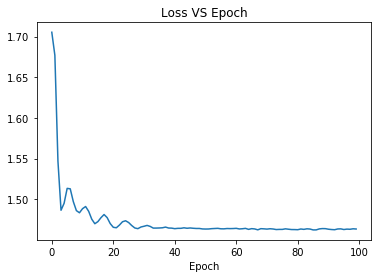

In [54]:
plt.title('Loss VS Epoch')
plt.xlabel("Loss")
plt.xlabel("Epoch")
plt.plot(loss_arr)

In [55]:
preds = []
with torch.no_grad():
    for val in X_test:
        y_hat = model.forward(val)
        preds.append(y_hat.argmax().item())

In [56]:
df = pd.DataFrame({'Y': y_test, 'YHat': preds})
df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y'], df['YHat'])]
df['diff'] = np.abs(df.Y - df.YHat) 

In [57]:
print(df.Y.mean())
print(df.YHat.mean())
print(df.YHat.min())
print(df.YHat.max())

3.349518029275259
3.987226784085049
3
4


In [58]:
df.head(100)

,Y,YHat,Correct,diff
0,5,4,0,1
1,4,4,1,0
2,3,4,0,1
3,3,4,0,1
4,2,4,0,2
...,...,...,...,...
95,4,4,1,0
96,4,4,1,0
97,2,4,0,2
98,3,4,0,1


In [59]:
df['Correct'].sum() / len(df)

0.3514221111507795

In [60]:
mae = df['diff'].mean()
mae

0.9114998611606966